In [1]:
import casatasks as ctask
import casatools as ctool
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS
from spectral_cube import SpectralCube as sc
import astropy.units as U
import warnings
warnings.filterwarnings('ignore')

In [2]:
path="G1-data/VLA/"
name=path+"J1403_briggs_contsub_pbcor.image"
newimage=path+'J1403-box.image'
cubeim=newimage+'.fits'
#ctask.imregrid(imagename=name,template='J2000',output=name+'.regrid',overwrite=True)
#ctask.imsubimage(imagename=name+'.regrid',outfile=newimage,region='centerbox [[80pix, 78pix], [60pix, 60pix]]',overwrite=True)#chans='15~47'
#ctask.exportfits(imagename=newimage, fitsimage=cubeim, overwrite=True)

"""testfits=fits.open(newimage+'.fits')
testfits.info()
hdr=testfits[0].header
data=fits.getdata(newimage+'.fits')
print(data.shape)"""


"testfits=fits.open(newimage+'.fits')\ntestfits.info()\nhdr=testfits[0].header\ndata=fits.getdata(newimage+'.fits')\nprint(data.shape)"

In [3]:
#Additional commands required to convert channel to vel and pix to coordinates

"""chan = np.arange(19,44,1)
ff, aa = plt.subplots(5,5,figsize=(20,16))
for ii, i in enumerate(chan):
    xx,yy= int(ii/5), int(ii%5)
    im = aa[xx,yy].imshow(fits.getdata(cubeim)[0,i,:,:])
    plt.colorbar(im, ax=aa[xx,yy])
    aa[xx,yy].set_title(i)"""

'chan = np.arange(19,44,1)\nff, aa = plt.subplots(5,5,figsize=(20,16))\nfor ii, i in enumerate(chan):\n    xx,yy= int(ii/5), int(ii%5)\n    im = aa[xx,yy].imshow(fits.getdata(cubeim)[0,i,:,:])\n    plt.colorbar(im, ax=aa[xx,yy])\n    aa[xx,yy].set_title(i)'

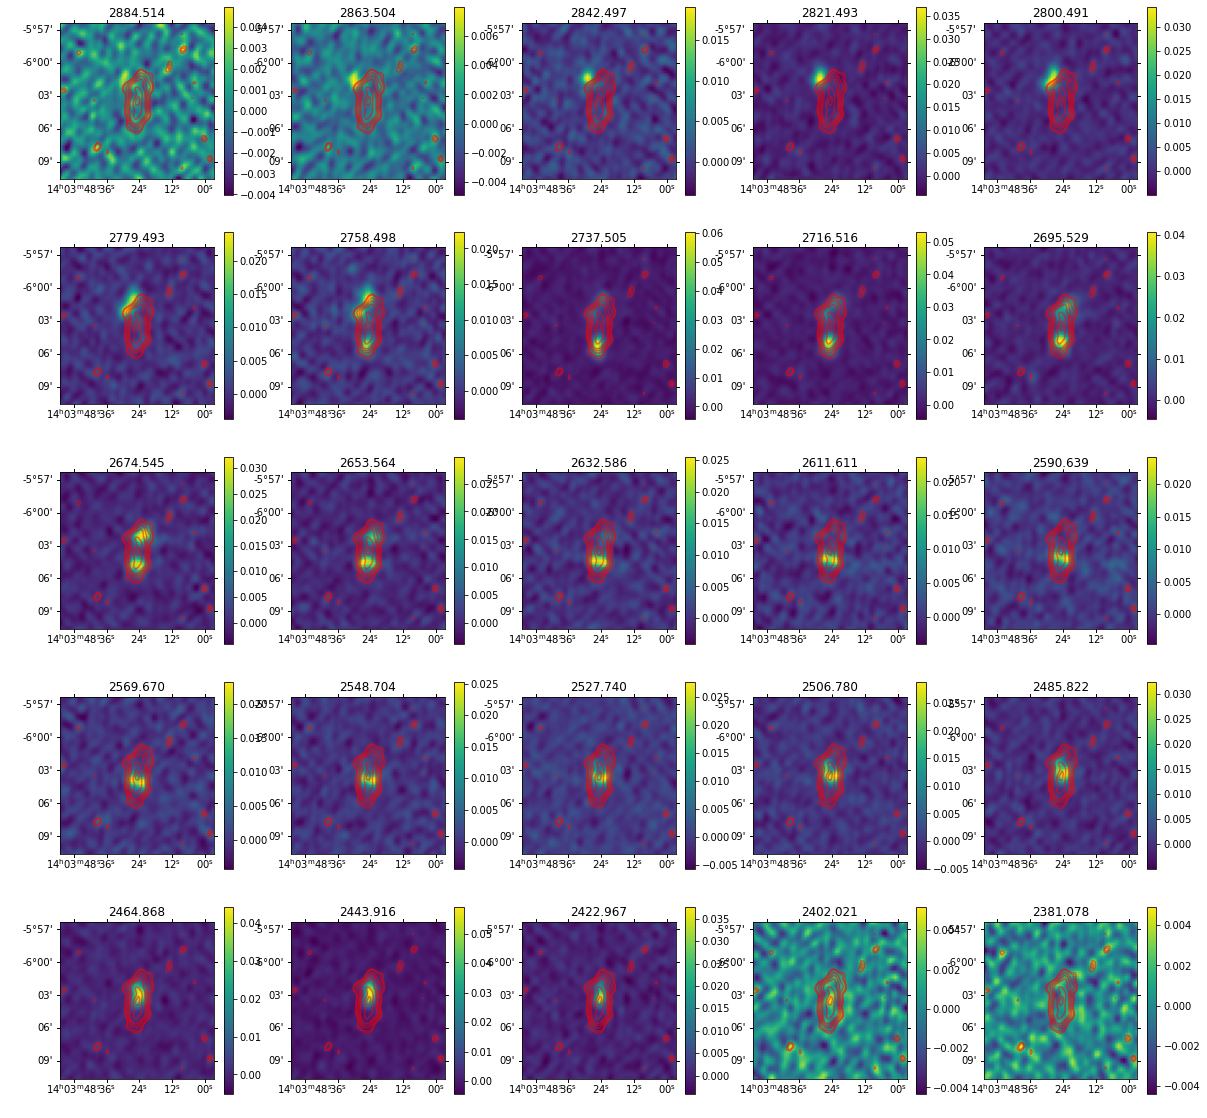

In [4]:
#Method 1 - Using Spectral Cube; There are other methods using casatask

newcube=sc.read(cubeim)
vel_rad=(newcube.with_spectral_unit(unit=U.km/U.s, velocity_convention='optical',rest_value=1.420405745510*U.GHz)).spectral_axis
#print(newcube.wcs.wcs_pix2world(0,0,0,0))

levels =[0.9, 1.15, 1.76, 2.37, 3.07, 4.8, 5.52]
momconto=fits.getdata(path+'sc-mom0.fits',interpolation='hanning')[:,:]

chan = np.arange(19,44,1)
plt.figure(figsize=(20,20))
for ii, i in enumerate(chan):
    ax = plt.subplot(5,5,ii+1, projection=newcube[0].wcs)
    im=ax.imshow(fits.getdata(cubeim)[0,i,:,:])
    ax.set_xlabel(' ')
    ax.set_ylabel(' ')
    plt.colorbar(im)
    ax.set_title('%.3f'%(vel_rad[i].value)) 
    ax.contour(momconto, colors=['red'], alpha=0.5, levels=levels)

#plot_channel_maps

In [5]:
#Moment Map with immoments

"""momimage=newimage+'.mom0'
ctask.immoments(imagename=cubeim,moments=[0],axis='spectral',chans='21~41',outfile=momimage)
ctask.exportfits(imagename=momimage, fitsimage=momimage+'.fits', overwrite=True)

fff,mo=plt.subplots(1,1,figsize=(16,16))
mom0=mo.imshow(fits.getdata(momimage+'.fits',interpolation='hanning')[0,0,:,:])
plt.colorbar(mom0,ax=mo)"""


"momimage=newimage+'.mom0'\nctask.immoments(imagename=cubeim,moments=[0],axis='spectral',chans='21~41',outfile=momimage)\nctask.exportfits(imagename=momimage, fitsimage=momimage+'.fits', overwrite=True)\n\nfff,mo=plt.subplots(1,1,figsize=(16,16))\nmom0=mo.imshow(fits.getdata(momimage+'.fits',interpolation='hanning')[0,0,:,:])\nplt.colorbar(mom0,ax=mo)"

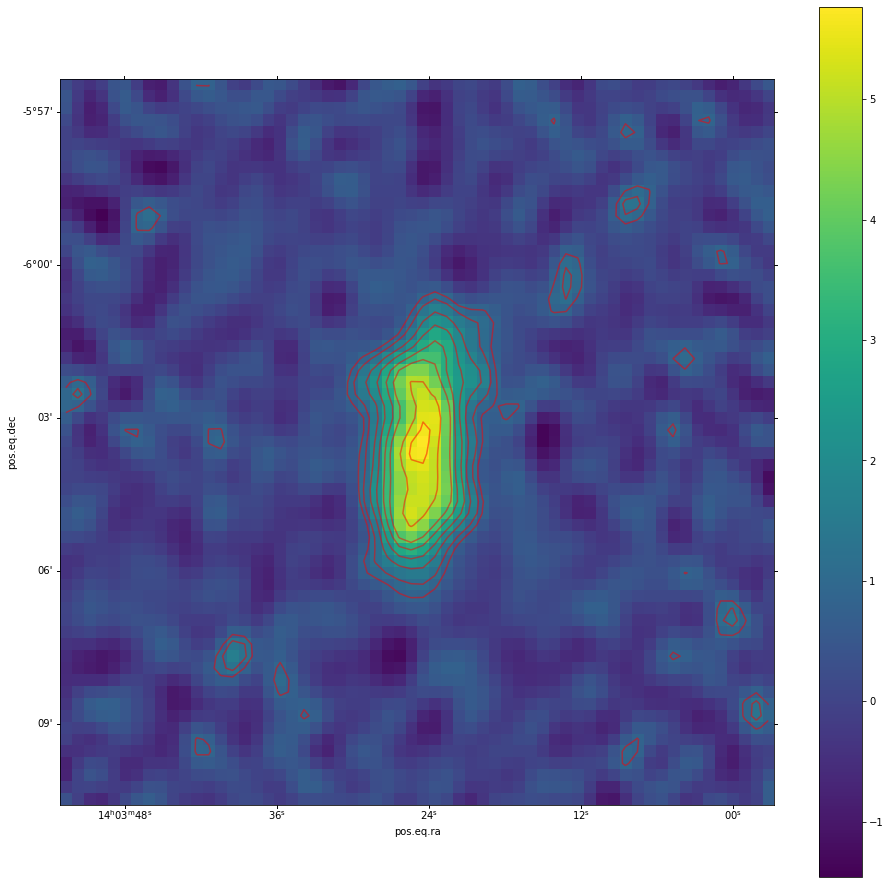

In [6]:
#Moment Map with Spectral Cube

velcube=newcube.with_spectral_unit(unit=U.km/U.s, velocity_convention='optical',rest_value=1.420405745510*U.GHz) #Converting cube to vel scale
velcube_chan=velcube.spectral_slab(2346*U.km/U.s,2765*U.km/U.s) #channel cuts
mom0_new=velcube_chan.moment(order=0,axis=0,how='auto') #mom0

# Convert Moment_0 to a Column Density assuming optically thin media
#NHI = mom0_new * 1.823 * 10**18 / (U.cm * U.cm) * U.s / U.K / U.km
mom0_new.write(path+'sc-mom0.fits', overwrite=True)

plt.figure(figsize=(16,16))
mo=plt.subplot(1,1,1,projection=velcube[0].wcs)
mom0=mo.imshow(fits.getdata(path+'sc-mom0.fits',interpolation='hanning')[:,:])
plt.colorbar(mom0,ax=mo)

levels =[0.8, 1.15, 1.76, 2.37, 3.07, 3.71, 4.88, 5.52]
mo.contour(fits.getdata(path+'sc-mom0.fits',interpolation='hanning')[:,:], colors=['red'], alpha=0.5, levels=levels)


In [7]:
#fullmom=name+'.regrid'+'.fullmom0'
#ctask.immoments(imagename=name+'.regrid',moments=[0],axis='spectral',chans='21~42',outfile=fullmom)

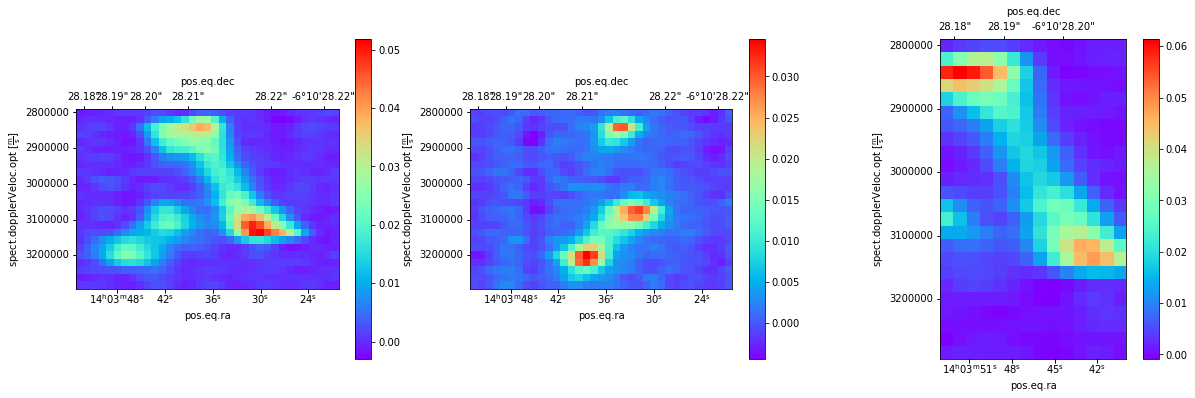

In [8]:
#PV Slice extractor and SpectralCube

from pvextractor import extract_pv_slice
from pvextractor.geometry import Path

fit=sc.read(cubeim).with_spectral_unit(unit=U.km/U.s, velocity_convention='optical',rest_value=1.420405745510*U.GHz)

g1 = [(27,47),(31,12)]
s1 = [(10,37),(45,37)]
s2 = [(31,34),(27,20)]
xyg1 = Path(g1)
xys1= Path(s1)
xys2 = Path(s2)
pvg1 = extract_pv_slice(fit[19:43,:,:], xyg1)
pvs1 = extract_pv_slice(fit[19:43,:,:], xys1)
pvs2 = extract_pv_slice(fit[19:43,:,:], xys2)

#pv.writeto(path+'my_slice.fits',) 

plt.figure(figsize=(20,20))
ag1 = plt.subplot(3,3,1,projection=fit.wcs,slices=('x',0,'y'))
pvg1im=ag1.imshow(pvg1.data, cmap='rainbow')
plt.colorbar(pvg1im)

as1 = plt.subplot(3,3,2,projection=fit.wcs, slices=('x',0,'y'))
pvs1im=as1.imshow(pvs1.data, cmap='rainbow')
plt.colorbar(pvs1im)
as2 = plt.subplot(3,3,3,projection=fit.wcs, slices=('x',0,'y'))
pvs2im=as2.imshow(pvs2.data, cmap='rainbow')
plt.colorbar(pvs2im)


In [9]:
#fit[:,29,29].quicklook()

(63,)


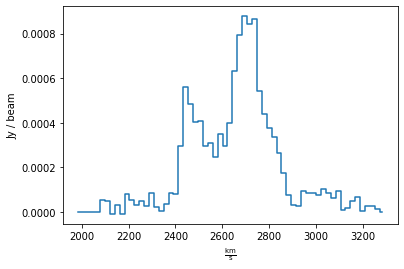

In [10]:
#Extract Spectrum

spec = fit.mean(axis=(1,2))  
print(spec.shape)
spec.quicklook()

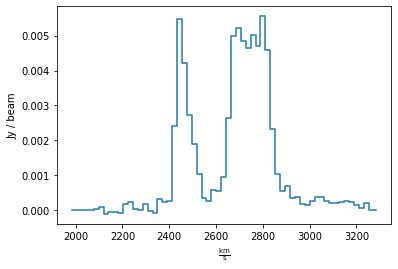

In [11]:
## Masked Spectrum Extraction -G1S1
import regions
#crtf_g1s1 = 'circle[[14:03:26.09, -06:01:01.75], 128"], coord=J2000'

ds9_g1s1 = 'J2000; circle(14:03:26.08764,-06:01:01.7474, 126")'  
cubeg1s1 = fit.subcube_from_ds9region(ds9_g1s1)
#cubeg1s1[25,:,:].quicklook()
specg1s1 = cubeg1s1.mean(axis=(1, 2))
specg1s1.quicklook()

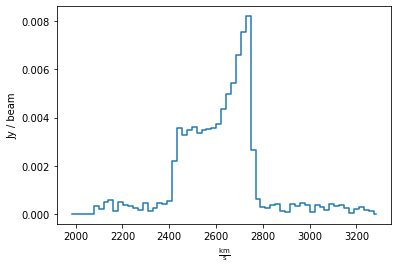

In [12]:
## Masked Spectrum Extraction -G1S2

ds9_g1s2 = 'J2000; circle(14:03:25.15795,-006:05:02.4656, 126")'  
cubeg1s2 = fit.subcube_from_ds9region(ds9_g1s2)  
#cubeg1s2[25,:,:].quicklook()
specg1s2 = cubeg1s2.mean(axis=(1, 2))
specg1s2.quicklook()

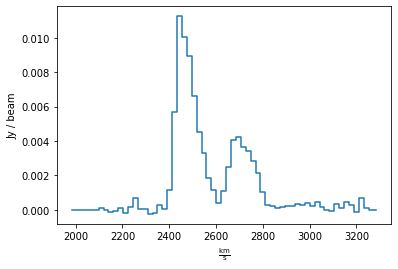

In [13]:
## Masked Spectrum Extraction -G1-bridge

bridgeg1 = regions.RectanglePixelRegion(regions.PixCoord(29.45, 31.96), width=21.76, height=2.43)  
cubeg1b = fit.subcube_from_regions([bridgeg1])
#cubeg1b[25,:,:].quicklook()
specg1b = cubeg1b.mean(axis=(1, 2)) 
specg1b.quicklook()

In [14]:
#Moment 1 for S1 and S2 using spectral cube - Need to add threshold cut off to eliminate effect of noise

"""g1s1_chan=cubeg1s1.spectral_slab(2346*U.km/U.s,2765*U.km/U.s) #channel cuts
mom1s1=g1s1_chan.moment(order=1,axis=0,how='auto') #mom1

#mom1s1.write(path+'g1s1-mom1.fits', overwrite=True)

plt.figure(figsize=(16,16))
g1s1m1=plt.subplot(1,2,1)
mom1s1plt=g1s1m1.imshow(mom1s1.value)
plt.colorbar(mom1s1plt,ax=g1s1m1)

g1s2_chan=cubeg1s2.spectral_slab(2346*U.km/U.s,2765*U.km/U.s) #channel cuts
mom1s2=g1s2_chan.moment(order=1,axis=0,how='auto') #mom1

#mom1s2.write(path+'g1s2-mom1.fits', overwrite=True)

#plt.figure(figsize=(16,16))
g1s2m1=plt.subplot(1,2,2)
mom1s2plt=g1s2m1.imshow(mom1s2.value)
plt.colorbar(mom1s2plt,ax=g1s2m1)"""


"g1s1_chan=cubeg1s1.spectral_slab(2346*U.km/U.s,2765*U.km/U.s) #channel cuts\nmom1s1=g1s1_chan.moment(order=1,axis=0,how='auto') #mom1\n\n#mom1s1.write(path+'g1s1-mom1.fits', overwrite=True)\n\nplt.figure(figsize=(16,16))\ng1s1m1=plt.subplot(1,2,1)\nmom1s1plt=g1s1m1.imshow(mom1s1.value)\nplt.colorbar(mom1s1plt,ax=g1s1m1)\n\ng1s2_chan=cubeg1s2.spectral_slab(2346*U.km/U.s,2765*U.km/U.s) #channel cuts\nmom1s2=g1s2_chan.moment(order=1,axis=0,how='auto') #mom1\n\n#mom1s2.write(path+'g1s2-mom1.fits', overwrite=True)\n\n#plt.figure(figsize=(16,16))\ng1s2m1=plt.subplot(1,2,2)\nmom1s2plt=g1s2m1.imshow(mom1s2.value)\nplt.colorbar(mom1s2plt,ax=g1s2m1)"

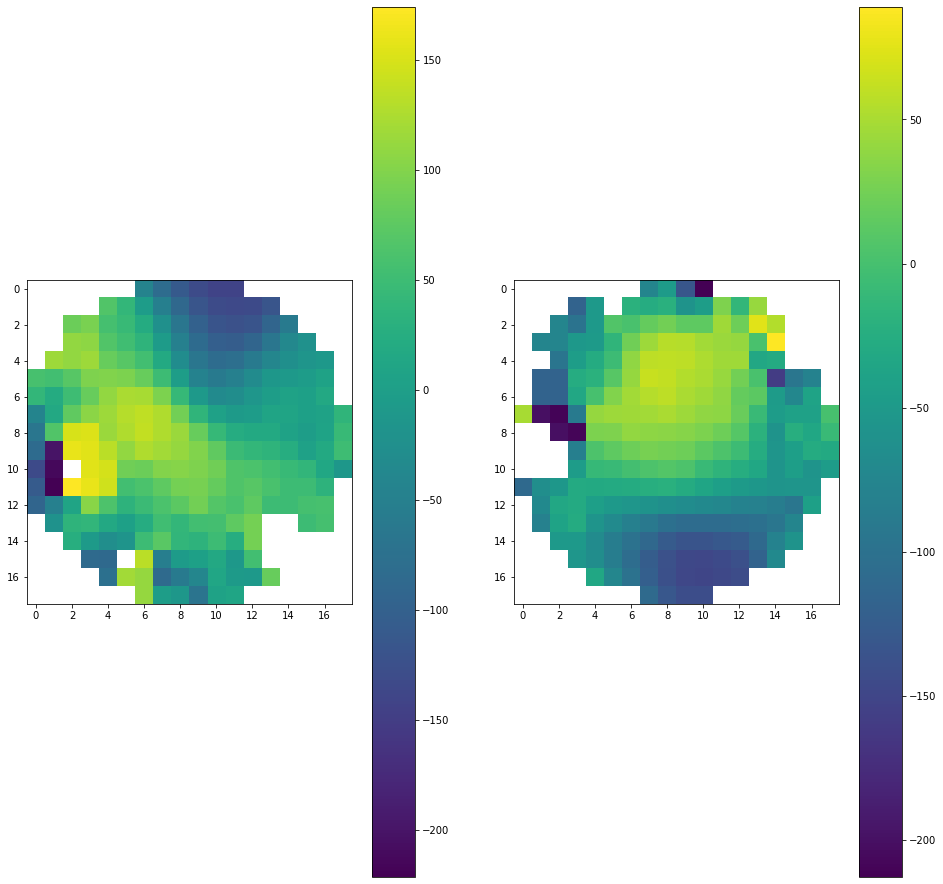

In [15]:
#Moment 1 for S1 and S2 usimg casa - Threshold at 1mJy

#ctask.immoments(imagename=cubeim,moments=[1],axis='spectral',chans='21~41',outfile=path+'g1s1-mom1',region='circle[[14h03m26.09s, -06d01m01.75s], 126arcsec]',includepix = [0.001,30])
#ctask.exportfits(imagename=path+'g1s1-mom1', fitsimage=path+'g1s1m1.fits', overwrite=True)

plt.figure(figsize=(16,16))
g1s1m1=plt.subplot(1,2,1)
mom1s1plt=g1s1m1.imshow(fits.getdata(path+'g1s1m1.fits')[0,0,:,:])
plt.colorbar(mom1s1plt,ax=g1s1m1)

#ctask.immoments(imagename=cubeim,moments=[1],axis='spectral',chans='21~41',outfile=path+'g1s2-mom1',region='circle[[14h03m25.15795s,-006d05m02.4656s], 126arcsec]',includepix = [0.001,30])
#ctask.exportfits(imagename=path+'g1s2-mom1', fitsimage=path+'g1s2m1.fits', overwrite=True)

g1s2m1=plt.subplot(1,2,2)
mom1s2plt=g1s2m1.imshow(fits.getdata(path+'g1s2m1.fits')[0,0,:,:])
plt.colorbar(mom1s2plt,ax=g1s2m1)


#Fix axis with wcs projection slice

In [16]:
print(mom0_new.unit)

Jy km / (beam s)
